# Measure and Graph Preformance of Stroke Matching Algorithm

In [1]:
import os
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import permutations, combinations
from math import factorial, log
from time import time

from xmlparse import loadRef, loadGeometryBases, getXmlScore, minXml, loadScores
from exhaustive import computeExhaustive, exhaustScore, exhaustScoreAlignment
from compare_genes import getScores, exhaustiveScores

#Insert your algorithm import here
from score_strokes import alignStrokes


2024-04-26T23:16:48.471217Z [INFO ] Stylus initialized - Stylus 1.5.0 [RELEASE - Aug 29 2023 15:40:46] (c) 2006-2009 Biologic Institute


In [2]:
#List of UTF-8 characters which will be used in the expermient - may be different than these
chars = ["4EFB", "5408", "5728", "5B57", "56E0", "5411"]

root_dir = "Genes/sixgenes"#"Genes/YOUR_DATA_HERE"

#Searches sub-directories for data
gene_dirs_stacked = [next(os.walk(f"{root_dir}/{child}")) for child in list(next(os.walk(root_dir))[1])]
gene_dirs = []
for root, _, children in gene_dirs_stacked:
    gene_dirs += [f"{root}/{child}" for child in children]

save_dir = "SixCharsExperiment/tables" #"YOUR_EXPERIMENT_HERE"

algorithm = alignStrokes #This is a compatable algorithm - put in your implementation here

In [3]:
def generateTables(save_dir, algorithm):
    exhaustive_tables = {}
    heuristic_tables = {}
    gene_id_table = []
    
    for gene_dir in gene_dirs:
        exhaustive_table = []
        heuristic_table = []
        marks_table = []
        
        file_components = gene_dir.split("/")
        min_score, han_char = file_components[2].split()[2], file_components[3].split(".")[1].split()[2]
        frame_title = f"Minimum Score: {min_score}, Han Char: {han_char}"
        
        for char in chars:
            exhaustive_scores = exhaustiveScores(char, gene_dir, save=True, file_prefix=f"{min_score}_")
            heuristic_scores, _, marks = getScores(algorithm, char, gene_dir)
            
            exhaustive_table.append(exhaustive_scores)
            heuristic_table.append(heuristic_scores)
            marks_table.append(marks)
    
        file_names = []
        for _, _, files in os.walk(gene_dir):
            for file in sorted(files):
                if file.endswith("gene"):
                    file_names.append(file)
        file_names = np.array(file_names)
    
        gene_ids = [f"{min_score}_{han_char}_{f}" for f in file_names]
        
        exhaustive_frame = pd.DataFrame({char: scores for (char, scores) in zip(chars, exhaustive_table)})
        heuristic_frame = pd.DataFrame({char: scores for (char, scores) in zip(chars, heuristic_table)})
    
        exhaustive_frame.insert(0, "GeneID", gene_ids)
        heuristic_frame.insert(0, "GeneID", gene_ids)
    
        exhaustive_frame.style.set_caption(f"{frame_title}, Exhaustive")
        exhaustive_frame.style.set_caption(f"{frame_title}, Heuristic")
    
        exhaustive_frame.to_csv(f"{save_dir}/{min_score}_{han_char}_exhaustive.csv", index=False)
        heuristic_frame.to_csv(f"{save_dir}/{min_score}_{han_char}_heuristic.csv", index=False)
        
        exhaustive_tables[gene_dir] = exhaustive_frame
        heuristic_tables[gene_dir] = heuristic_frame
        
        gene_id_table += [(gene_id, f"{gene_dir}/{f}", scores[han_char], mark) for gene_id, f, scores, mark in zip(gene_ids, file_names, exhaustive_frame.loc, marks_table[chars.index(han_char)])]
    
    gene_id_frame = pd.DataFrame(gene_id_table, columns=["GeneID", "Filepath", "Score", "Mark"])
    gene_id_frame.to_csv(f"{save_dir}/gene_table.csv", index=False)

    return exhaustive_tables, heuristic_tables, gene_id_table


In [4]:
#Regenerate tables if this is true, but skip if not
regenerate_tables = False
if regenerate_tables:
    exhaustive_tables, heuristic_tables, gene_id_table = generateTables(save_dir)

In [5]:
def readTables(save_dir):
    exhaustive_tables = {}
    heuristic_tables = {}
    gene_id_table = []
    for gene_dir in gene_dirs:
        file_components = gene_dir.split("/")
        min_score, han_char = file_components[-2].split()[0].split("_")[1], file_components[-1].split(".")[0]
        
        exhaustive_frame = pd.read_csv(f"{save_dir}/{min_score}_{han_char}_exhaustive.csv")
        heuristic_frame = pd.read_csv(f"{save_dir}/{min_score}_{han_char}_heuristic.csv")
        
        exhaustive_tables[gene_dir] = exhaustive_frame
        heuristic_tables[gene_dir] = heuristic_frame
    
    gene_id_table = pd.read_csv(f"{save_dir}/gene_table.csv")

    return exhaustive_tables, heuristic_tables, gene_id_table

if not regenerate_tables:
    exhaustive_tables, heuristic_tables, gene_id_table = readTables(save_dir)

['Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.9.gene', 'Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.13.gene', 'Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.11.gene', 'Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.17.gene', 'Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.19.gene', 'Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.3.gene', 'Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.16.gene', 'Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.12.gene', 'Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.20.gene', 'Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.15.gene', 'Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.10.gene', 'Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.14.gene', 'Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.1.gene', 'Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.18.gene', 'Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.8.gene', 'Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.5.gene', 'Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.6.gene', 'Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.7.gene', 'Genes/sixgenes/maint_0.2 on 56E0.2/56E0.2.2.gene', 

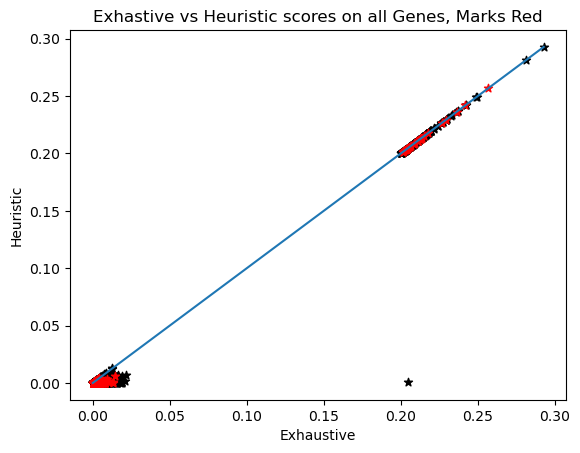

In [6]:
graphs_dir = "Graphs"

print(gene_dirs)
gene_dir_selection = gene_dirs[10]

score_file_ids = exhaustive_tables[gene_dir_selection].to_numpy()[:,0]
gene_table_selection = gene_id_table.loc[gene_id_table["GeneID"].isin(score_file_ids)]
filter_marks = gene_table_selection["Mark"] == False
filter_marks_true = gene_table_selection["Mark"] == True

print(exhaustive_tables[gene_dir_selection].to_numpy().shape)

exhaustive_scores, heuristic_scores = exhaustive_tables[gene_dir_selection].to_numpy()[filter_marks,1:].flatten(), heuristic_tables[gene_dir_selection].to_numpy()[filter_marks,1:].flatten()
exhaustive_scores_m, heuristic_scores_m = exhaustive_tables[gene_dir_selection].to_numpy()[filter_marks_true,1:].flatten(), heuristic_tables[gene_dir_selection].to_numpy()[filter_marks_true,1:].flatten()

box_bound = exhaustive_scores[1:].max()
print(exhaustive_scores.shape, filter_marks.shape)

#plt.plot(exhaustive_scores, heuristic_scores, "k*")
plt.scatter(exhaustive_scores, heuristic_scores, c="black", marker="*")
plt.scatter(exhaustive_scores_m, heuristic_scores_m, c="red", marker="*")
plt.plot([0, box_bound], [0, box_bound])
plt.xlabel(f"Exhaustive")
plt.ylabel(f"Heuristic")
plt.title(f"Exhastive vs Heuristic scores on all Genes, Marks Red")
plt.savefig(f"{graphs_dir}/six_char_gene_dir.png")


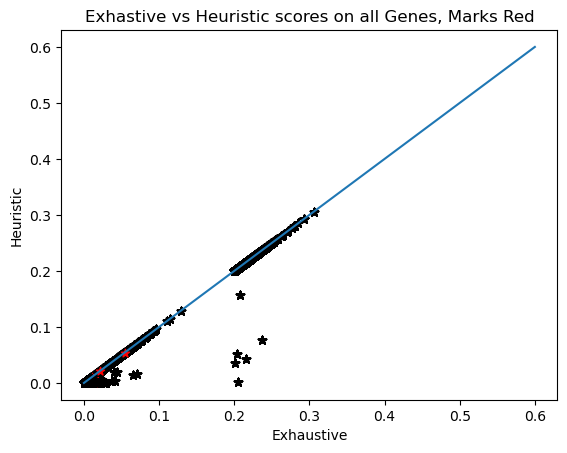

In [7]:
graphs_dir = "Graphs"

hit_scores = []
miss_scores = []

all_exhaustives = []
all_heuristics = []

plt.plot([0, 0.6], [0, 0.6])

for gene_dir in gene_dirs:
    score_file_ids = exhaustive_tables[gene_dir].to_numpy()[:,0]
    gene_table_selection = gene_id_table.loc[gene_id_table["GeneID"].isin(score_file_ids)]
    filter_marks = gene_table_selection["Mark"] == False
    filter_marks_true = gene_table_selection["Mark"] == True
    
    exhaustive_scores, heuristic_scores = exhaustive_tables[gene_dir].to_numpy()[filter_marks,1:].flatten(), heuristic_tables[gene_dir].to_numpy()[filter_marks,1:].flatten()
    exhaustive_scores_m, heuristic_scores_m = exhaustive_tables[gene_dir].to_numpy()[filter_marks_true,1:].flatten(), heuristic_tables[gene_dir].to_numpy()[filter_marks_true,1:].flatten()
    
    if exhaustive_scores.shape[0] == 0:
        continue

    mismatches = exhaustive_tables[gene_dir] != heuristic_tables[gene_dir]
    matches = exhaustive_tables[gene_dir] == heuristic_tables[gene_dir]
    mismatches["GeneID"] = exhaustive_tables[gene_dir]["GeneID"]

    hits = matches[matches["4EFB"] | matches["5408"] | matches["5728"] | matches["5B57"] | matches["56E0"] | matches["5411"]]
    misses = mismatches[mismatches["4EFB"] & mismatches["5408"] & mismatches["5728"] & mismatches["5B57"] & mismatches["56E0"] & mismatches["5411"]]

    all_exhaustives += list(exhaustive_scores)
    all_heuristics += list(heuristic_scores)

    hit_scores += list(exhaustive_tables[gene_dir].iloc[hits.index, 1:].max(axis=1))
    miss_scores += list(exhaustive_tables[gene_dir].iloc[misses.index, 1:].max(axis=1))    
    
    plt.scatter(exhaustive_scores, heuristic_scores, c="black", marker="*")
    plt.scatter(exhaustive_scores_m, heuristic_scores_m, c="red", marker="*")
    plt.xlabel(f"Exhaustive")
    plt.ylabel(f"Heuristic")
    plt.title(f"Exhastive vs Heuristic scores on all Genes, Marks Red")
    plt.savefig(f"{graphs_dir}/six_char_gene_dir.png")

all_exhaustives = np.array(all_exhaustives)
all_heuristics = np.array(all_heuristics)

hit_scores = np.array(hit_scores)
miss_scores = np.array(miss_scores)

filt_02 = all_exhaustives < 0.2
filt_04 = (all_exhaustives >= 0.2)*(all_exhaustives < 0.4)
filt_06 = (all_exhaustives >= 0.4)*(all_exhaustives < 0.6)
match = (all_exhaustives - all_heuristics)/all_exhaustives > 0.01
match_02 = match[filt_02]
match_04 = match[filt_04]
match_06 = match[filt_06]


In [8]:
n = 100

bins = [0]
hit_percent = []
miss_percent = []
miss_points = []
x_points = []

for i in range(n-1):
    filt_h = (hit_scores >= (i/n))*(hit_scores<(i+1)/n)
    filt_m = (miss_scores >= (i/n))*(miss_scores<(i+1)/n)
    hit_filt = hit_scores[filt_h]
    miss_filt = miss_scores[filt_m]
    if hit_filt.shape[0] != 0 or miss_filt.shape[0] != 0:
        #print(f"{(i/n)} <= s < {((i+1)/n)} = {miss_filt.shape[0]/(hit_filt.shape[0]+miss_filt.shape[0])}")
        miss_points.append((miss_filt.shape[0]/(hit_filt.shape[0]+miss_filt.shape[0]), (i+1)/n))
        x_points.append((i+0.5)/n)
        miss_percent.append(miss_filt.shape[0]/(hit_filt.shape[0]+miss_filt.shape[0]))
        hit_percent.append(1-miss_percent[-1])
        bins.append((i+1)/n)


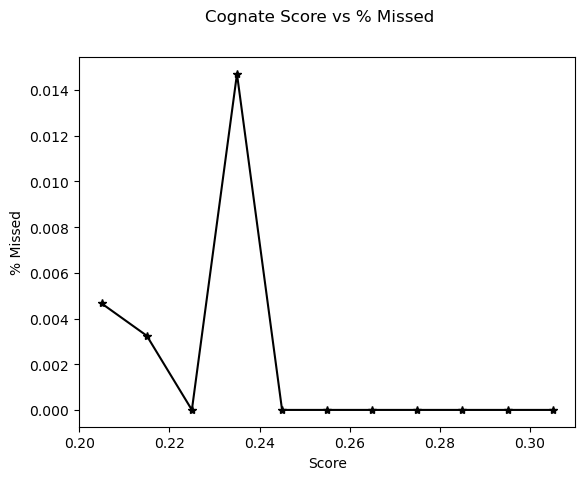

In [9]:
plt.xlabel("Score")
plt.ylabel("% Missed")
plt.suptitle("Cognate Score vs % Missed")
#plt.yscale("log")

plt.plot(x_points, miss_percent, "-k*")
plt.savefig("cognate_scorevmissed_log.png")
#log scale plot
#ax x scale to log

In [10]:
n = 100

bins = [0]
hit_percent = []
miss_percent = []
miss_points = []
x_points = []

for i in range(n-1):
    filt = (all_exhaustives >= (i/n))*(all_exhaustives<(i+1)/n)
    match = (all_exhaustives - all_heuristics)/all_exhaustives < 0.01
    if match.shape[0] != 0 and match[filt].shape[0] != 0:
        matches = match[filt]
        #print(f"{(i/n)} <= s < {((i+1)/n)} = {np.sum(matches)/matches.shape[0]}")
        x_points.append((i+0.5)/n)
        hit_percent.append(np.sum(matches)/matches.shape[0])
        miss_percent.append(1-hit_percent[-1])
        bins.append((i+1)/n)


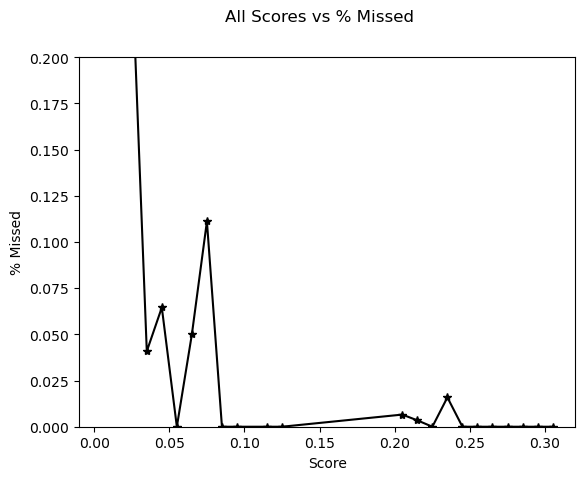

In [11]:
plt.xlabel("Score")
plt.ylabel("% Missed")
plt.suptitle("All Scores vs % Missed")
#plt.yscale("log")
plt.ylim([0.0, 0.2])

plt.plot(x_points, miss_percent, "-k*")

plt.savefig("noncognate_scorevmissed.png")